# Compare to Experimental Data

We show how to compare `yadism` predictions to an HERA measurement (see [here](https://www.desy.de/h1zeus/herapdf20) for an overview),
specifically [this dataset](https://www.hepdata.net/record/ins1377206?version=1&table=Table%205).

## Preparing the dataset

Our dataset can be downloaded from the NNPDF server:

In [1]:
!wget -q -N https://data.nnpdf.science/yadism/HERA12B2_NCem.dat

In [2]:
import pandas as pd

# Load the experimental data via pandas
data = pd.read_csv("HERA12B2_NCem.dat", sep="\s+")

data[["x", "Q2", "Sigma"]]

,x,Q2,Sigma
0,0.0008,60.0,1.483100
1,0.0013,90.0,1.466000
2,0.0015,90.0,1.421900
3,0.0020,90.0,1.270000
4,0.0016,120.0,1.438800
...,...,...,...
154,0.4000,20000.0,0.205990
155,0.6500,20000.0,0.017364
156,0.4000,30000.0,0.230730
157,0.6500,30000.0,0.044179


## Computing the yadism predictions

We are now going to compute the `yadism` predictions at the same kinematic points as provided by the experimental measurements. First, we need to prepare the theory and observable cards.

In [3]:
import warnings
import yadism
from eko import interpolation
from yadbox.export import dump_pineappl_to_file

In [4]:
theory_card = {
    "PTO": 2,
    "FNS": "ZM-VFNS",
    "DAMP": 0,
    "IC": 1,
    "IB": 0,
    "ModEv": "TRN",
    "ModSV": "unvaried",
    "XIR": 1.0,
    "XIF": 1.0,
    "NfFF": 5,
    "MaxNfAs": 5,
    "MaxNfPdf": 5,
    "Q0": 1.65,
    "alphas": 0.118,
    "Qref": 91.2,
    "nf0": 4,
    "nfref": 5,
    "QED": 0,
    "alphaqed": 0.007496252,
    "Qedref": 1.777,
    "SxRes": 0,
    "SxOrd": "LL",
    "HQ": "POLE",
    "mc": 1.51,
    "Qmc": 1.51,
    "kcThr": 1.0,
    "mb": 4.92,
    "Qmb": 4.92,
    "kbThr": 4.0,
    "mt": 172.5,
    "Qmt": 172.5,
    "ktThr": 1.0,
    "CKM": "0.97428 0.22530 0.003470 0.22520 0.97345 0.041000 0.00862 0.04030 0.999152",
    "MZ": 91.1876,
    "MW": 80.398,
    "GF": 1.1663787e-05,
    "SIN2TW": 0.23126,
    "TMC": 1,
    "MP": 0.938,
    "global_nx": 0,
    "EScaleVar": 1,
    "kDIScThr": 1.0,
    "kDISbThr": 1.0,
    "kDIStThr": 1.0,
    "n3lo_cf_variation": 0,
}

In [5]:
observables_card = {
    "PolarizationDIS": 0.0,
    "ProjectileDIS": "electron",
    "PropagatorCorrection": 0.0,
    "TargetDIS": "proton",
    "interpolation_is_log": True,
    "interpolation_polynomial_degree": 4,
    "interpolation_xgrid": interpolation.lambertgrid(60).tolist(),
    "observables": {"XSHERANC_total": []},
    "prDIS": "NC",
    "NCPositivityCharge": None,
}

In [6]:
def compute_predicionts() -> None:
    """Compute yadism prediction for all experimental bins."""
    # prepare the kinematics for all the datapoints
    curobs = data.apply(
        lambda dat: {"x": dat["x"], "Q2": dat["Q2"], "y": dat["y"]},
        axis=1,
    )

    # Update the observable & kinematics in the `observable_card`
    obs_def = {
        "observables" : {"XSHERANC_total": list(curobs.to_dict().values())}
    } # As we saw in the previous tutorial, it has to be a dict[dict[list]]
    observables_card.update(obs_def)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # suppress noisy warnings
        out = yadism.run_yadism(theory_card, observables_card)

    # Dump computations as a pineappl grid for later use
    dump_pineappl_to_file(
        out, "HERA_NC_318GEV_EM_SIGMARED.pineappl.lz4", "XSHERANC_total"
    )

In [7]:
# Compute the predictions - slightly heavier due to complexity & number of datapoints
compute_predicionts()

┌────────────────────────────────────┐                                       
                                      │                                    │                                       
                                      │ __     __       _ _                │                                       
                                      │ \ \   / /      | (_)               │                                       
                                      │  \ \_/ /_ _  __| |_ ___ _ __ ___   │                                       
                                      │   \   / _` |/ _` | / __| '_ ` _ \  │                                       
                                      │    | | (_| | (_| | \__ \ | | | | | │                                       
                                      │    |_|\__,_|\__,_|_|___/_| |_| |_| │                                       
                                      │                                    │                                       
                                      └────────────────────────────────────┘

Plan

 • XSHERANC_total at 159 pts

Calculation

yadism took off! please stay tuned ...

Output()

took 86.98 s

## Loading and comparing to HERA

Now, that we have our pre-computed predictions in the form of a PineAPPL grid, we can compare the results to the HERA measurements. To do so, we can load the grid and convolute it with a PDF set, specifically the NNLO NNPDF4.0 set.

In [8]:
import lhapdf
import pineappl

In [9]:
# Load only the central member
pdf = lhapdf.mkPDF("NNPDF40_nnlo_as_01180", 0)

LHAPDF 6.4.0 loading /home/felix/local/share/LHAPDF/NNPDF40_nnlo_as_01180/NNPDF40_nnlo_as_01180_0000.dat
NNPDF40_nnlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331100


In [10]:
# Load the pre-computed grid
grid = pineappl.grid.Grid.read("HERA_NC_318GEV_EM_SIGMARED.pineappl.lz4")

# Convolute with the PDF
yadism_data = grid.convolute_with_one(2212, pdf.xfxQ2, pdf.alphasQ2)

In [11]:
# Combine the exp measurements and Yadism preds into one table
data_vs_yadism_df = pd.concat(
    [
        data["Q2"],
        data["x"],
        data["Sigma"],
        pd.DataFrame([yadism_data], index=["yadism"]).T,
    ],
    axis=1,
)

Finally, we can compare our theory predictions and the experimental data graphically.

In [12]:
import matplotlib.pyplot as plt

def plot_comparisons_q2(df: pd.DataFrame, q2_value: float = 300) -> None:
    fig, ax = plt.subplots(figsize=(5, 3.75), layout="tight")

    # Select corresponding Q2 values
    df_q2 = df[df.Q2 == q2_value]

    # Plot measurements and yadism preds
    ax.plot(df_q2.x, df_q2["Sigma"], "o", label="EXP")
    ax.plot(df_q2.x, df_q2["yadism"], "rs", label="Yadism")

    ax.set_xlabel("x")
    ax.set_ylabel("xsec")
    ax.legend()
    ax.set_xscale("log")
    ax.set_title(f"HERA: $Q^2 = {q2_value}~ \\mathrm{{GeV}}^2$")

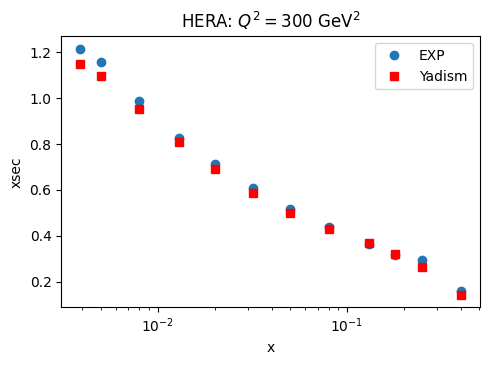

In [13]:
plot_comparisons_q2(data_vs_yadism_df)

Note that we are using the ZM-VFNS here, so we don't expect perfect agreement as heavy quark effects are only entering through the PDF evolution.